In [1]:
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.metrics import silhouette_score
import numpy as np

In [2]:
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import linkage
import matplotlib.pyplot as plt

# Load the feature files and combine the features
features_ctl_c = pd.read_csv('./miRNA/50_ctl_c.csv')['Feature'].tolist()
features_ctl_b = pd.read_csv('./miRNA/50_ctl_b.csv')['Feature'].tolist()
features_b_c = pd.read_csv('./miRNA/50_b_c.csv')['Feature'].tolist()

all_selected_features = list(set(features_ctl_c + features_ctl_b + features_b_c))

print(len(all_selected_features))  # Ensure the total number of unique features

103


In [3]:
# Load and prepare the original stage data
ctl_samples = pd.read_csv('../data/control/control_samples.csv')
benign_samples = pd.read_csv('../data/benign/benign_prostate_samples.csv')
cancer_samples = pd.read_csv('../data/cancer/prostate_cancer_samples.csv')

# Add stage column for easier concatenation
ctl_samples['Stage'] = 'Control'
benign_samples['Stage'] = 'Benign'
cancer_samples['Stage'] = 'Cancer'

In [4]:

# Combine all stages data
combined_data = pd.concat([ctl_samples, benign_samples, cancer_samples], ignore_index=True)

# Ensure only numeric columns are used
numeric_columns = combined_data.columns.drop(['Sample_ID', 'Sex', 'Age', 'Stage', 'Disease'])

# Calculate the average expression levels for each miRNA for each stage
average_expression = combined_data.groupby('Stage')[numeric_columns].mean().T

# Ensure all selected features are present in the data
selected_features_in_data = [feature for feature in all_selected_features if feature in average_expression.index]

print("Features present in data:", len(selected_features_in_data))

# Print missing features
missing_features = set(all_selected_features) - set(selected_features_in_data)
if missing_features:
    print("Missing features:", missing_features)

# Extract the selected features from the average expression data
selected_expression = average_expression.loc[selected_features_in_data]

# Normalize each miRNA across stages
normalized_expression = selected_expression.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

# Check if the normalization removes any miRNAs
print("Normalized expression shape:", normalized_expression.shape)

Features present in data: 103
Normalized expression shape: (103, 3)


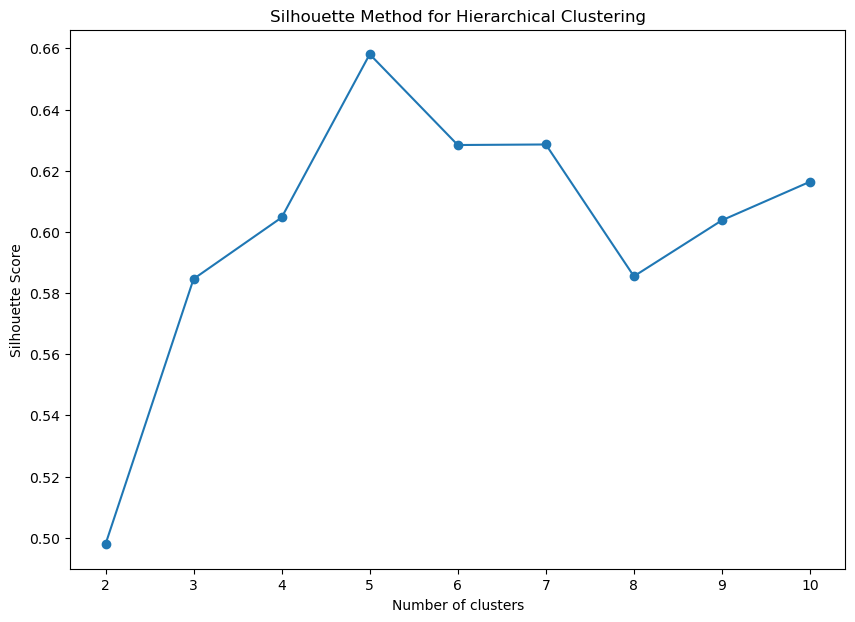

<Figure size 1500x1000 with 0 Axes>

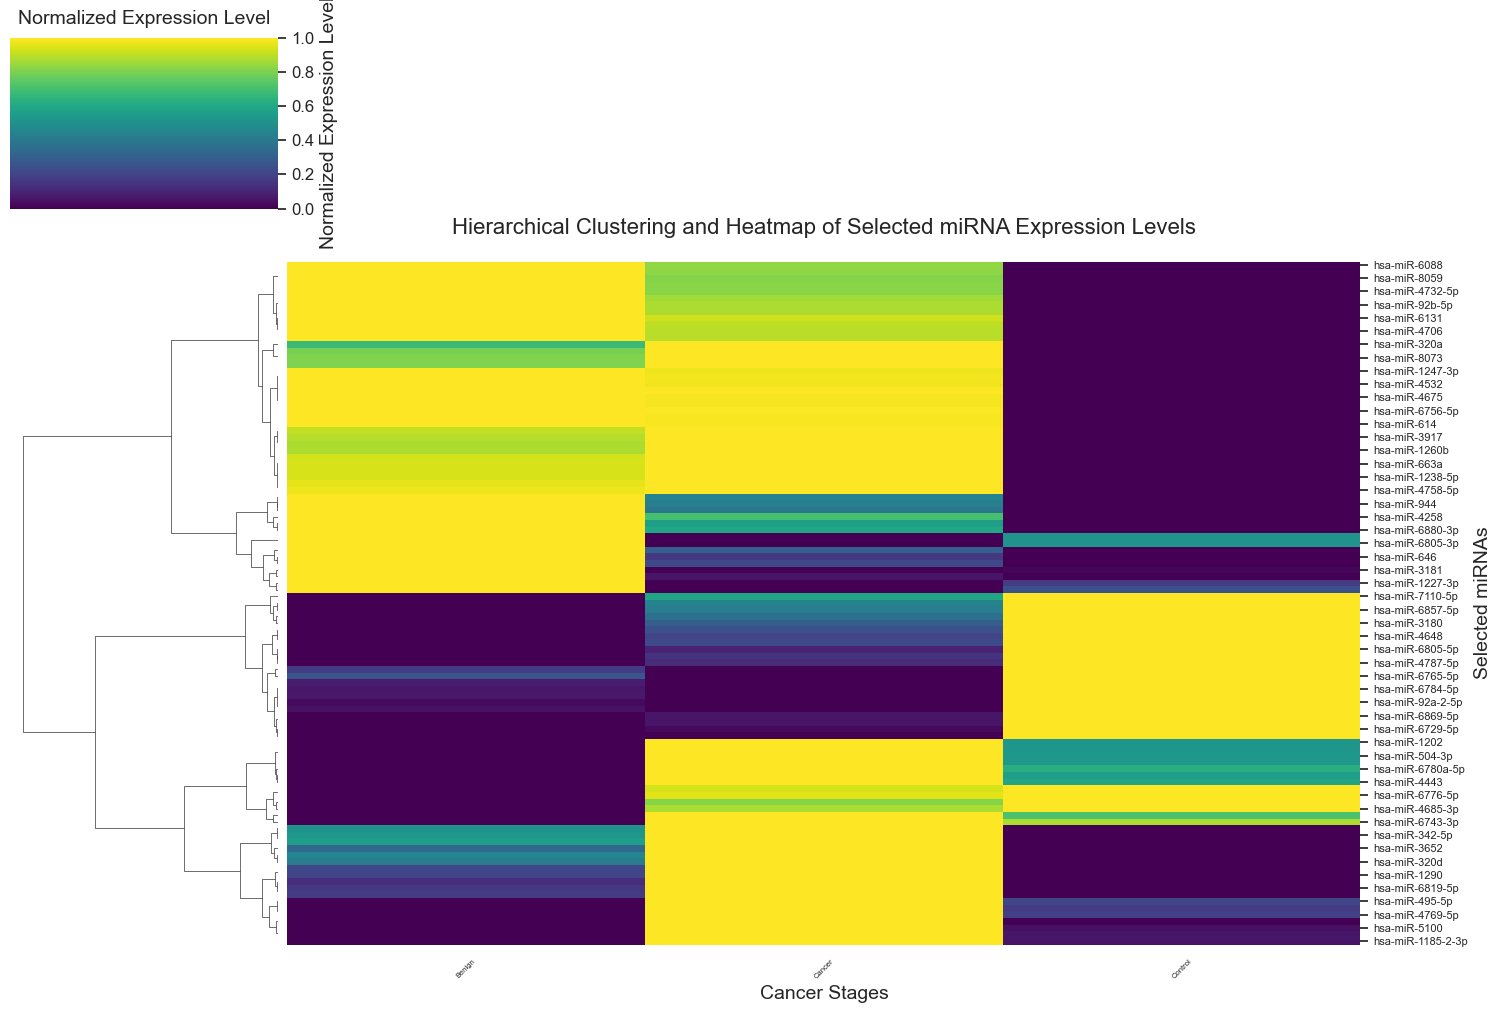

Cluster 1:
hsa-miR-1307-3p
hsa-miR-1469
hsa-miR-4783-3p
hsa-miR-4787-3p
hsa-miR-8059
hsa-miR-8073
hsa-miR-3917
hsa-miR-663a
hsa-miR-6088
hsa-miR-1238-5p
hsa-miR-197-5p
hsa-miR-6746-5p
hsa-miR-320a
hsa-miR-1247-3p
hsa-miR-1260b
hsa-miR-6787-5p
hsa-miR-6756-5p
hsa-miR-92b-5p
hsa-miR-4675
hsa-miR-4687-5p
hsa-miR-4734
hsa-miR-4706
hsa-miR-1233-5p
hsa-miR-4758-5p
hsa-miR-1343-3p
hsa-miR-614
hsa-miR-6131
hsa-miR-642b-3p
hsa-miR-4532
hsa-miR-4732-5p
hsa-miR-4419b
hsa-miR-6802-5p
hsa-miR-6861-5p
hsa-miR-4690-5p
hsa-miR-6769a-5p
Cluster 2:
hsa-miR-1224-5p
hsa-miR-646
hsa-miR-4258
hsa-miR-6880-3p
hsa-miR-944
hsa-miR-941
hsa-miR-3181
hsa-miR-940
hsa-miR-4313
hsa-miR-6805-3p
hsa-miR-1227-3p
hsa-miR-4456
hsa-miR-1470
hsa-miR-516a-5p
hsa-miR-31-3p
Cluster 3:
hsa-miR-4481
hsa-miR-7110-5p
hsa-miR-1203
hsa-miR-92a-2-5p
hsa-miR-6857-5p
hsa-miR-128-1-5p
hsa-miR-6869-5p
hsa-miR-6784-5p
hsa-miR-4787-5p
hsa-miR-4276
hsa-miR-3940-5p
hsa-miR-575
hsa-miR-125a-3p
hsa-miR-6729-5p
hsa-miR-4648
hsa-miR-1228-5p
hsa

In [5]:
# Perform hierarchical clustering on the normalized data -- do complete link
linked = linkage(normalized_expression, method='ward')

# Determine the optimal number of clusters using Silhouette Method
max_clusters = 10
silhouette_scores = []
for i in range(2, max_clusters + 1):
    clusters = fcluster(linked, i, criterion='maxclust')
    silhouette_scores.append(silhouette_score(normalized_expression, clusters))

plt.figure(figsize=(10, 7))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Silhouette Method for Hierarchical Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Create a heatmap with dendrogram
plt.figure(figsize=(15, 10))
sns.set(font_scale=0.5)  # Reduce font scale for better visibility
clustermap = sns.clustermap(normalized_expression, row_linkage=linked, col_cluster=False, cmap='viridis', figsize=(15, 10))

# Enhance the heatmap
clustermap.ax_heatmap.set_title('Hierarchical Clustering and Heatmap of Selected miRNA Expression Levels', fontsize=16, pad=20)
clustermap.ax_heatmap.set_xlabel('Cancer Stages', fontsize=14)
clustermap.ax_heatmap.set_ylabel('Selected miRNAs', fontsize=14)
clustermap.ax_heatmap.tick_params(axis='x', rotation=45)

# Set y-tick labels to ensure all miRNAs are displayed
clustermap.ax_heatmap.set_yticklabels(clustermap.ax_heatmap.get_yticklabels(), rotation=0, fontsize=8)  # Adjust fontsize for y-tick labels

# Add color bar legend with a title
cbar = clustermap.ax_heatmap.collections[0].colorbar
cbar.set_label('Normalized Expression Level', fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Set color bar title
cbar.ax.set_title('Normalized Expression Level', fontsize=14, pad=10)

plt.tight_layout()
plt.show()

# Assign clusters for 4 groups
num_clusters = 5
clusters = fcluster(linked, num_clusters, criterion='maxclust')

# Create a DataFrame for miRNA clusters
miRNA_clusters = pd.DataFrame({'miRNA': normalized_expression.index, 'Cluster': clusters})

# Save miRNA clusters to a CSV file (optional, for reference)
miRNA_clusters.to_csv('miRNA_clusters.csv', index=False)

# Print miRNAs in each cluster
for cluster_id in range(1, num_clusters + 1):
    cluster_miRNAs = normalized_expression.index[clusters == cluster_id].tolist()
    print(f"Cluster {cluster_id}:")
    # print the miRNAs in each cluster separated by a new line
    print("\n".join(cluster_miRNAs))

- For each of the 7 different groups from hierarchical clustering, choose one miRNA and perform analysis on it to give a sample from that group
	- ANOVA Statistical Analysis
	- Post HOC Analysis
	- Plot expression over groups using bar plot

## Specific Sampling from the 7 Clusters

ANOVA result for hsa-miR-3178: F=nan, p=nan


/Users/emmetthintz/miniconda3/envs/myenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1  group2 meandiff p-adj  lower  upper  reject
---------------------------------------------------
Benign  Cancer   0.1195    0.0 0.1012 0.1377   True
Benign Control   0.1328    0.0  0.116 0.1496   True
Cancer Control   0.0134 0.0007 0.0049 0.0218   True
---------------------------------------------------


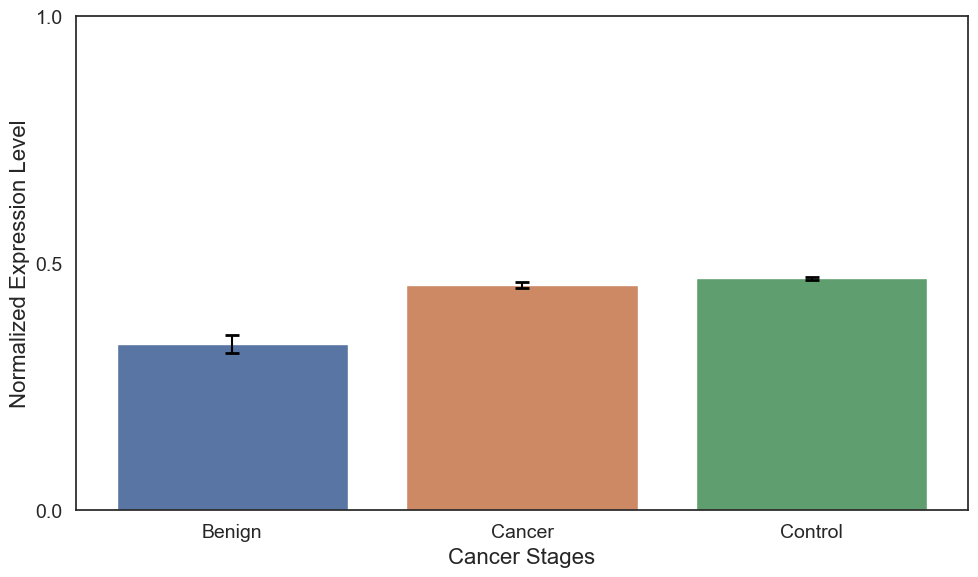

ANOVA result for hsa-miR-7846-3p: F=nan, p=nan


/Users/emmetthintz/miniconda3/envs/myenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj  lower   upper  reject
----------------------------------------------------
Benign  Cancer  -0.0445   0.0 -0.0566 -0.0323   True
Benign Control  -0.0299   0.0 -0.0411 -0.0187   True
Cancer Control   0.0146   0.0  0.0089  0.0202   True
----------------------------------------------------


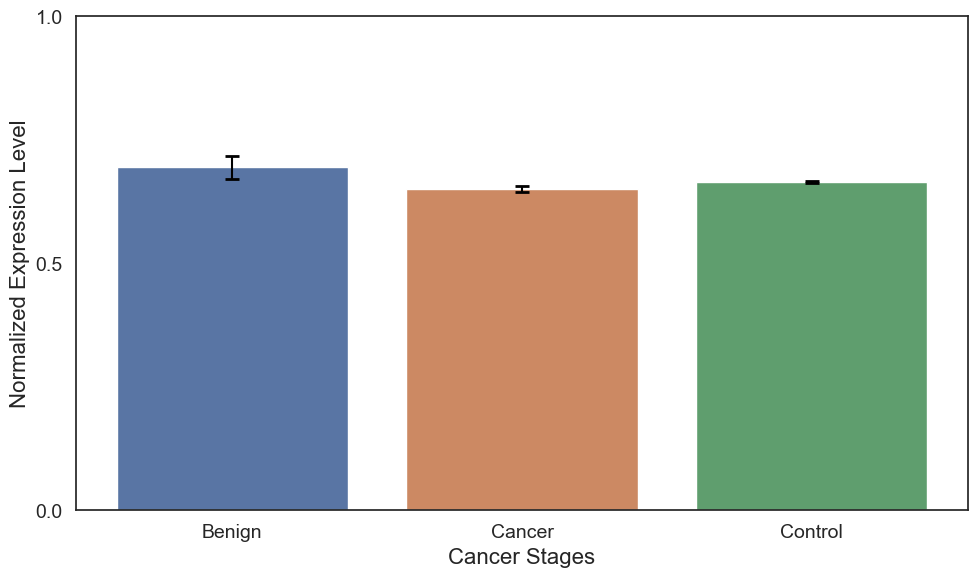

ANOVA result for hsa-miR-5591-5p: F=nan, p=nan


/Users/emmetthintz/miniconda3/envs/myenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
Benign  Cancer    0.035 0.0017  0.0111  0.0588   True
Benign Control  -0.0681    0.0 -0.0901 -0.0461   True
Cancer Control  -0.1031    0.0 -0.1142  -0.092   True
-----------------------------------------------------


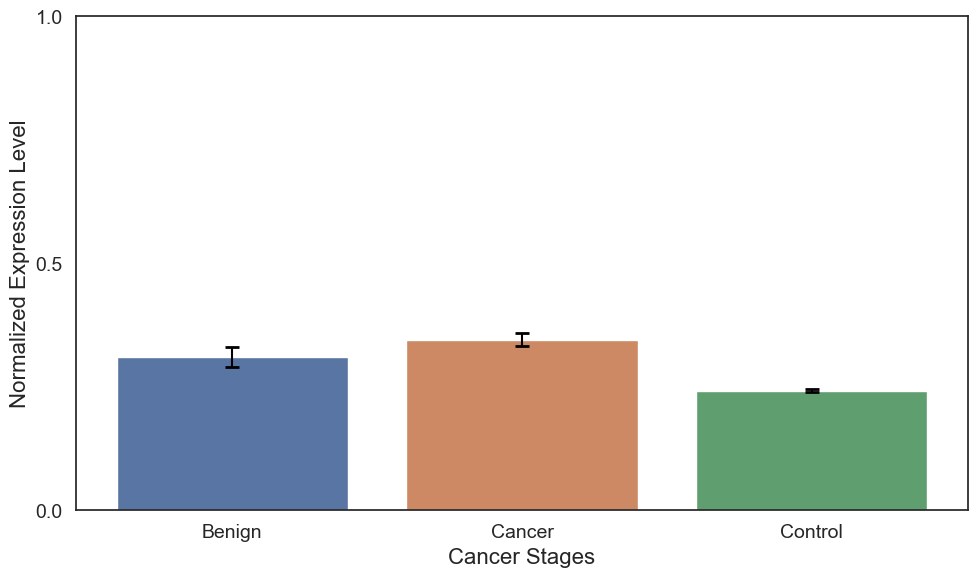

ANOVA result for hsa-miR-548ah-5p: F=nan, p=nan


/Users/emmetthintz/miniconda3/envs/myenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
Benign  Cancer  -0.0169  0.106 -0.0364  0.0027  False
Benign Control  -0.0208 0.0186 -0.0389 -0.0028   True
Cancer Control  -0.0039 0.5689  -0.013  0.0052  False
-----------------------------------------------------


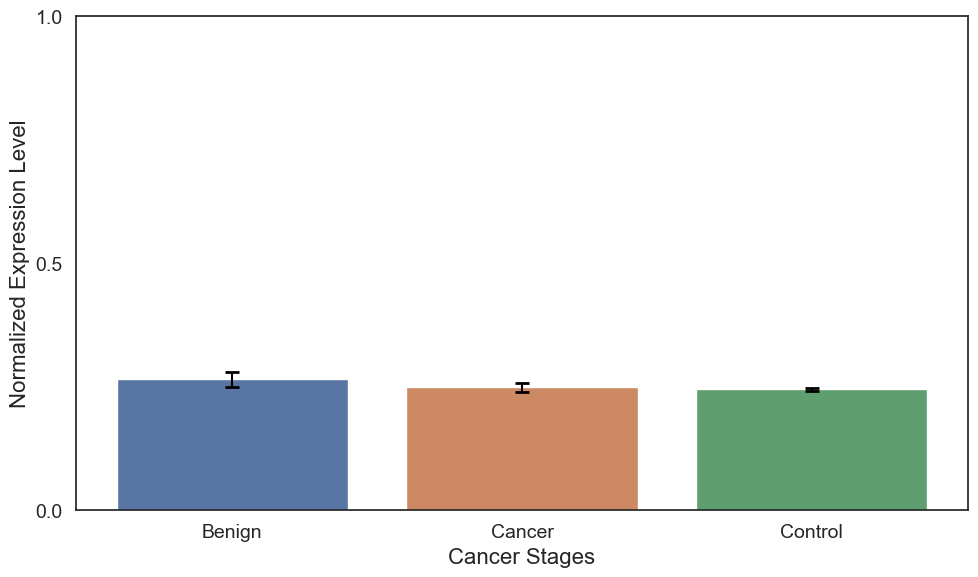

ANOVA result for hsa-miR-4474-3p: F=nan, p=nan


/Users/emmetthintz/miniconda3/envs/myenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
Benign  Cancer  -0.0493 0.0019 -0.0831 -0.0154   True
Benign Control   0.1347    0.0  0.1035  0.1659   True
Cancer Control    0.184    0.0  0.1683  0.1997   True
-----------------------------------------------------


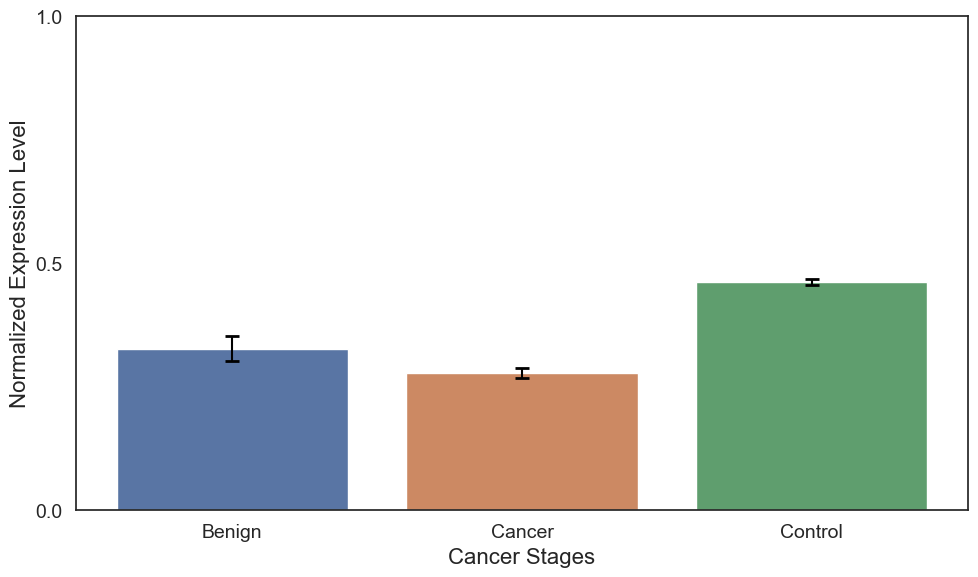

ANOVA result for hsa-miR-937-5p: F=nan, p=nan


/Users/emmetthintz/miniconda3/envs/myenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1  group2 meandiff p-adj lower  upper  reject
--------------------------------------------------
Benign  Cancer   0.1514   0.0 0.1401 0.1627   True
Benign Control   0.2176   0.0 0.2072  0.228   True
Cancer Control   0.0662   0.0 0.0609 0.0714   True
--------------------------------------------------


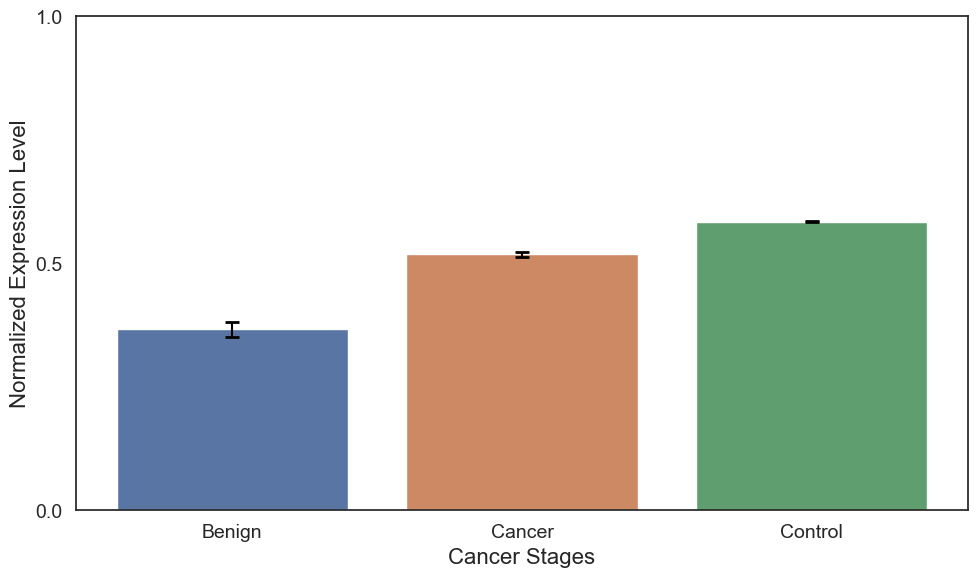

ANOVA result for hsa-miR-4462: F=nan, p=nan


/Users/emmetthintz/miniconda3/envs/myenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj  lower   upper  reject
----------------------------------------------------
Benign  Cancer  -0.0565   0.0 -0.0704 -0.0426   True
Benign Control   -0.071   0.0 -0.0838 -0.0582   True
Cancer Control  -0.0145   0.0 -0.0209  -0.008   True
----------------------------------------------------


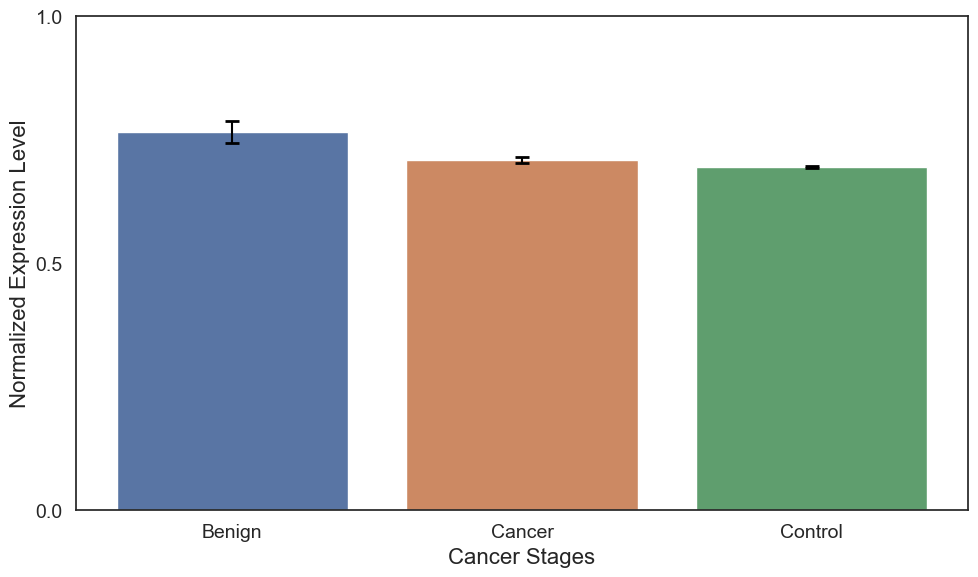

In [6]:
# List of specific miRNAs to analyze
miRNAs_to_analyze = ['hsa-miR-3178', 'hsa-miR-7846-3p', 'hsa-miR-5591-5p', 'hsa-miR-548ah-5p', 'hsa-miR-4474-3p', 'hsa-miR-937-5p', 'hsa-miR-4462']

sns.set_style("white")

plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('font', size=14)     

# Perform ANOVA and Post Hoc analysis on specified miRNAs
for miRNA in miRNAs_to_analyze:
    miRNA_data = combined_data[['Stage', miRNA]]
    miRNA_data = miRNA_data.dropna()

    # Normalize within each miRNA across all stages
    miRNA_data['Normalized'] = miRNA_data.groupby('Stage')[miRNA].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

    # ANOVA on normalized data
    anova_result = f_oneway(
        miRNA_data[miRNA_data['Stage'] == 'Stage 1']['Normalized'],
        miRNA_data[miRNA_data['Stage'] == 'Stage 2']['Normalized'],
        miRNA_data[miRNA_data['Stage'] == 'Stage 3']['Normalized'],
        miRNA_data[miRNA_data['Stage'] == 'Stage 4']['Normalized']
    )

    print(f"ANOVA result for {miRNA}: F={anova_result.statistic}, p={anova_result.pvalue}")

    # Post Hoc Analysis with Tukey HSD on normalized data
    tukey_result = pairwise_tukeyhsd(endog=miRNA_data['Normalized'], groups=miRNA_data['Stage'], alpha=0.05)
    print(tukey_result)

    mean_data = miRNA_data.groupby('Stage')['Normalized'].mean().reset_index()
    sem_data = miRNA_data.groupby('Stage')['Normalized'].sem().reset_index()
    mean_data['2*SEM'] = 2 * sem_data['Normalized']

    # Plot normalized expression over groups using bar plot
    plt.figure(figsize=(10, 6))
    bar_plot = sns.barplot(x='Stage', y='Normalized', data=mean_data)
    
    # Add error bars with horizontal caps
    for i, stage in enumerate(mean_data['Stage']):
        plt.errorbar(x=i, y=mean_data.loc[i, 'Normalized'], yerr=mean_data.loc[i, '2*SEM'], fmt='none', c='black', capsize=5, capthick=2)

    plt.xlabel('Cancer Stages')
    plt.ylabel('Normalized Expression Level')
    plt.yticks([0, 0.5, 1])
    plt.tight_layout()
    plt.show()